In [1]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfc = tf.contrib
tfd = tf.contrib.distributions

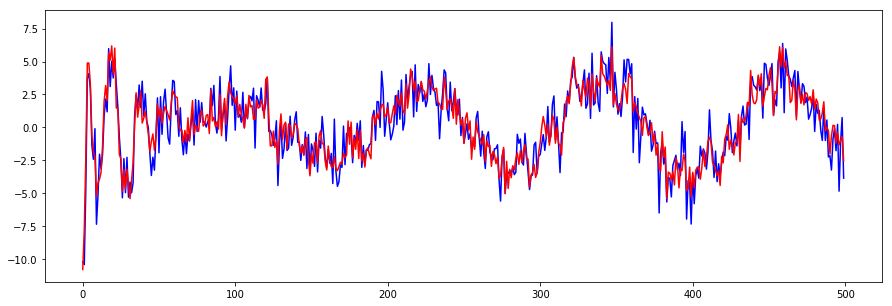

In [2]:
np.random.seed(1)
n_hidden = 50; seq_length = 500;
h = np.zeros((seq_length + 1, n_hidden)); h[0] = np.random.randn(1, n_hidden)
y = np.zeros((seq_length + 1, 1)); y[0] = np.random.randn(1)
sigma_c = 1.2
sigma_b = 1

A = 0.8 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.02 * np.random.randn(1, n_hidden)
b = np.random.randn(n_hidden, 1)
c = 0.5 * np.random.randn(n_hidden, 1)
bias_h = 0

for i in range(1, seq_length + 1):
    h[i] = 0.3 * np.tanh(np.dot(h[i-1], R) + np.dot(y[i-1], B)) + 0.7 * h[i-1]
#     y[i] = 10 * np.tanh(np.dot(h[i], b)) + np.dot(h[i], c) * np.random.randn()
    y[i] = 10 * np.tanh(np.dot(h[i], b)) + sigma_b * np.random.randn()

# y_tilde = (y[1:] + (1.2 * np.maximum(0, 2 * np.tanh(2 * y[1:] - 4)) + 0.5) * np.random.randn(seq_length, 20)).T
y_tilde = (y[1:] + sigma_c * np.random.randn(seq_length, 20)).T
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[0], 'b')
plt.plot(y[1:], 'r')
ts = y_tilde[-1]

In [3]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [4]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std=None, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._std = std[None, None] if std is not None else None
        self._layer_h = tf.layers.Dense(50, tf.nn.tanh)
        self._layer_m = tf.layers.Dense(event_size)
        if std is None:
            self._layer_s = tf.layers.Dense(event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        _, state = self._cell(inputs, state)
        hidden = self._layer_h(state)
        mean = self._layer_m(hidden)
        if self._std is not None:
            batch_size = state.shape[0]
            std = tf.tile(self._std, [batch_size, 1])
        else:
            std = self._layer_s(hidden)
        return (mean, std), state
    
    def call_no_input(self, state):
        hidden = self._layer_h(state)
        mean = self._layer_m(hidden)
        if self._std is not None:
            batch_size = state.shape[0]
            std = tf.tile(self._std, [batch_size, 1])
        else:
            std = self._layer_s(hidden)
        return (mean, std), state
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)

In [ ]:
class RobustARGenerator(object):
    
    def __init__(self, data, n_hidden=100, n_samples=15, seq_length=100, batch_size=1):
        self._data = data                                         # B x T x 1
        self._H = n_hidden                                        # H
        self._B = batch_size                                      # B
        self._S = n_samples                                       # S
        self._T = seq_length                                      # T
        
        self._cell = tf.nn.rnn_cell.BasicRNNCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, 1)
        self._post_cell_z = tfc.rnn.GRUBlockCell(self._H)
        self._post_cell_f = tfc.rnn.GRUBlockCell(self._H)
        self._post_cell_b = tfc.rnn.GRUBlockCell(self._H)
        self._post_std = tf.nn.softplus(
                                tf.get_variable('post_stddev', shape=(), 
                                        initializer=tf.constant_initializer(1))
        )
        
        self._invgamma_a0 = 1.; self._invgamma_a1 = 1.
        self._invgamma_b0 = 1.; self._invgamma_b1 = 1.
        
        self._trans_invgamma_a0 = 1.; self._trans_invgamma_a1 = 1.
        self._trans_invgamma_b0 = 1.; self._trans_invgamma_b1 = 1.
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self.compute_elbo
        self.E_step
        self.M_step
        
#         self.make_forward_posterior
#         self.make_forward_parameters
#         self.compute_forward_message
#         self.compute_elbo_forward
#         self.forward_E_step
#         self.forward_M_step
        
    @define_scope
    def make_posterior_z(self):
        _, h = tf.nn.dynamic_rnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._H)
        stds = tf.layers.dense(h, self._H, tf.nn.softplus)
        return tfd.MultivariateNormalDiag(means, scale_diag=stds)
    
    @define_scope
    def make_entropy_z(self):
        return tf.reduce_sum(tf.linalg.logdet(self.make_posterior_z.covariance()))
    
    @define_scope
    def make_kl_z(self):
        entropy = self.make_entropy_z
        exponent_z = tf.square(self.make_posterior_z.mean())
        norm_z = self._B * tf.linalg.logdet(tf.eye(self._H))
        return - entropy + tf.reduce_sum(exponent_z) + norm_z
    
    @define_scope
    def make_posterior(self):
        hidden = tf.reshape(self._code_z, [-1, self._H])
        data_inputs = tf.tile(self._data[None, ...], (self._S, 1, 1, 1))
        data_inputs = tf.reshape(data_inputs, [-1, self._T, 1]) # (S * B) x T x 1
        (out_f, out_b), _ = tf.nn.bidirectional_dynamic_rnn(
                                                self._post_cell_f, 
                                                self._post_cell_b, 
                                                inputs=data_inputs,
                                                initial_state_fw=hidden, 
                                                dtype=tf.float32
        )
        
        hidden = tf.concat([out_f, out_b], 2)
        hidden = tf.layers.dense(hidden, 2 * self._H, tf.nn.tanh)
        means = tf.layers.dense(hidden, 1) # (S * B) x T x 1
        means = tf.identity(means, name='post_means') 
        return tfd.MultivariateNormalDiag(means[..., 0], scale_identity_multiplier=self._post_std)
    
    @define_scope
    def make_entropy_y(self):
        return self._T * self._B * tf.log(tf.square(self._post_std))
    
    @define_scope
    def make_transitional(self):
        trans_invgamma = tfd.InverseGamma(self._trans_invgamma_a1, self._trans_invgamma_b1)
        
        hidden = tf.reshape(self._code_z, [-1, self._H])[None, ...]
        hidden = tf.tile(hidden, [self._S, 1, 1])
        hidden = tf.reshape(hidden, [-1, self._H]) # (S * S * B) * H
        inputs = self._code[:, :-1] # (S * S * B) x (T - 1)
        
        (mean1, _), _ = self._gauss_cell.call_no_input(hidden)
        (means, _), _ = tf.nn.dynamic_rnn(self._gauss_cell, inputs=inputs, initial_state=hidden)
        
        variances = trans_invgamma.sample((self._S * self._S * self._B, self._T)) # (S * S * B) x T
        return tf.concat([mean1, means[..., 0]], 1), variances
    
    @define_scope
    def make_kl_y(self):
        entropy = self.make_entropy_y
        
        (means, variances) = self.make_transitional
        means = tf.reshape(means, [self._S, self._S, self._B, self._T])
        variances = tf.reshape(variances, [self._S, self._S, self._B, self._T])
        code = tf.reshape(self._code, [self._S, self._S, self._B, self._T])
        exponent_trans = tf.square(code - means)/variances
        
        self._trans_exp = tf.square(code - means)
        norm_trans = tf.reduce_sum(tf.reduce_mean(tf.log(variances), [0, 1]))
        norm_exp = tf.reduce_sum(tf.reduce_mean(exponent_trans, [0, 1]))
    
        return - entropy + norm_exp + norm_trans
    
    @define_scope
    def make_reconstruction(self):
        invgamma = tfd.InverseGamma(self._invgamma_a1, self._invgamma_b1)
        gen_vars = invgamma.sample((self._S * self._S,  self._B, self._T))
        code = tf.reshape(self._code, [self._S * self._S, self._B, self._T])
        self._exponent_gen = tf.square(code - self._data[None, ..., 0])
        exponent_gen = tf.reduce_sum(tf.reduce_mean(self._exponent_gen/gen_vars, 0))
        norm_gen = tf.reduce_sum(tf.reduce_mean(tf.log(gen_vars), 0))
        return - exponent_gen - norm_gen
    
    @define_scope
    def compute_elbo(self):      
        posterior_z = self.make_posterior_z
        self._code_z = posterior_z.sample((self._S)) # S x B x H
        
        posterior = self.make_posterior
        code = posterior.sample((self._S)) # S x (S x B) x T
        self._code = tf.reshape(code, [-1, self._T, 1])
        
        entropy_y = self.make_entropy_y
        entropy_z = self.make_entropy_z
        entropy = entropy_y + entropy_z
        
        kl_y = self.make_kl_y
        kl_z = self.make_kl_z
        kl = kl_y + kl_z
        
        reconstruction = self.make_reconstruction     
        loss = reconstruction - kl
        return loss, kl, reconstruction, entropy
    
    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_posterior' in v.name]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        self._invgamma_a1 = self._invgamma_a0 + (self._T * self._B)/2
        self._invgamma_b1 = self._invgamma_b0 + tf.reduce_sum(tf.reduce_mean(self._exponent_gen, 0))/2
        self._trans_invgamma_a1 = self._trans_invgamma_a0 + (self._T * self._B)/2
        self._trans_invgamma_b1 = self._trans_invgamma_b0 + tf.reduce_sum(tf.reduce_mean(self._trans_exp, [0, 1]))/2
        
        non_post_var = [v for v in tf.trainable_variables() if not 'make_posterior' in v.name]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=non_post_var)
    
    @define_scope
    def make_forward_posterior(self):
        y_mu = tf.get_variable('forward_y_mean', shape=(), initializer=tf.constant_initializer(0))
        y_sigma = tf.nn.softplus(tf.get_variable('forward_y_std', shape=(), initializer=tf.constant_initializer(2)))
        y_dist = tfd.Normal(y_mu, y_sigma)
        return y_dist

    @define_scope
    def make_forward_parameters(self):
        return tf.get_variable('best_forward_sequence', shape=(100,), initializer=tf.constant_initializer(0))

    @define_scope
    def make_forward_noisy(self):
        means = self.make_forward_parameters[..., None]
        stddevs = tfd.InverseGamma(self._invgamma_alpha1, self._invgamma_beta1).sample((100))
        return tfd.MultivariateNormalDiag(tf.transpose(means), scale_diag=stddevs).sample()
    
    @define_scope
    def compute_forward_message(self):
        h = self._code_z
        h = h[:, 0]
        code = tf.reshape(self._code, [self._n_samples, self._batch_size, self._seq_length])
        for t in range(self._seq_length):
            _, h = self._cell(code[:, 0, t, None], h)
            h = tf.tile(tf.reduce_mean(h, 0, keep_dims=True), [self._n_samples, 1])
        
        dist_y = tfd.Normal(self.make_posterior.mean()[0, -1], self._post_std)
        return dist_y, h
    
    @define_scope
    def forward_E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_forward_posterior')]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)
    
    @define_scope
    def forward_M_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_forward_parameters')]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)
    
    @define_scope
    def make_rnn_forward(self):
        _, hT = self.compute_forward_message
        hT = tf.tile(tf.reduce_mean(hT, 0, keep_dims=True), [self._n_samples, 1])
        fake_inputs = tf.zeros((self._n_samples, 100, 1))
        post_samples = self.make_forward_posterior.sample((self._n_samples))
        (means, stddevs), _ = tf.nn.dynamic_rnn(self._sampling_cell, inputs=fake_inputs, 
                                                initial_state=(hT, post_samples[..., None]))
        return means, stddevs
    
    @define_scope
    def compute_elbo_forward(self):
        self._sampling_cell = SamplingCell(self._gauss_cell, 1, self._n_samples)
        
        post = self.make_forward_posterior
        post_samples = post.sample((self._n_samples))
        entropy = tf.log(tf.square(post.scale))
        
        dist_y, _ = self.compute_forward_message
        means, stddevs = self.make_rnn_forward
        
        pred = self.make_forward_parameters
        reconstruction_exp = tf.square(pred[None, :] - means[..., 0])/tf.square(stddevs[..., 0])
        reconstruction_norm = tf.reduce_sum(tf.reduce_mean(tf.log(tf.square(stddevs)), 0))
        reconstruction = - tf.reduce_mean(tf.reduce_sum(reconstruction_exp, -1)) - reconstruction_norm
        
        cross = tf.square(dist_y.mean() - post_samples)/tf.square(dist_y.scale)
        kl = - entropy + tf.reduce_mean(cross) + tf.log(tf.square(dist_y.scale))
        
        return reconstruction - kl, kl, reconstruction, entropy

In [ ]:
tf.reset_default_graph()
tf.set_random_seed(1234)

seq_length = 120; batch_size = 10;
data = []; test = []
indexes = [0]
data.append(y_tilde[0, :seq_length])
test.append(y_tilde[-1, :seq_length])
for i in range(1, batch_size):
    t = i * 10; indexes.append(t)
    data.append(y_tilde[i, t:t+seq_length])
    test.append(y_tilde[-(i+1), (i*15):(i*15+seq_length)])
batch = np.stack(data, 0); test_batch = np.stack(test, 0)

x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])
gen_model = RobustARGenerator(x_, n_hidden=50, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

elbos = []; kls = []; llks = []; entropies = []; test_elbos = []; elbos_forward = []
means = []; post_samples = []; post_means = []

for i in range(15001):
    elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo, {x_: batch[..., None]})
    elbos.append(elbo); kls.append(kl); llks.append(llk); entropies.append(entropy)
    
#     means_op = tf.get_default_graph().get_tensor_by_name('make_posterior/post_means:0')
#     post_means.append(sess.run(means_op, {x_: batch[..., None]})[0])
    m, _ = sess.run(gen_model.make_transitional, {x_: batch[..., None]}); means.append(m)
    latents = sess.run(gen_model._code, {x_: batch[..., None]})
    post_samples.append(latents)
    
    if i % 250 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy)        
       
#         initializers = [var.initializer for var in tf.global_variables() if 'forward' in var.name]
#         sess.run(initializers)
              
#         for i in range(2001):   
#             elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: test_batch[..., None]})
#             sess.run(gen_model.forward_E_step, {x_: test_batch[..., None]})
#             sess.run(gen_model.forward_M_step, {x_: test_batch[..., None]})
            
#         print('Iteration:', i, 'ELBO Forward:', elbo_forward)
        
#         elbos_forward.append(elbo_forward)
#         noisy_pred = sess.run(gen_model.make_forward_noisy, {x_: test_batch[..., None]})
#         true_forw = y_tilde[-1, seq_length:seq_length+100]
#         mse = sum((noisy_pred[0] - true_forw) ** 2)/100
#         print('Prediction MSE:', mse)
            
    
    sess.run(gen_model.E_step, {x_: batch[..., None]})
    sess.run(gen_model.M_step, {x_: batch[..., None]})

Iteration: 0 ELBO: -11610.9 KL: 2827.41 Reconstruction: -8783.5 Entropy: 248.702
Iteration: 250 ELBO: -3793.27 KL: 606.075 Reconstruction: -3187.19 Entropy: 2668.55
Iteration: 500 ELBO: -2587.22 KL: -9.28711 Reconstruction: -2596.51 Entropy: 2865.87
Iteration: 750 ELBO: -1975.44 KL: -356.495 Reconstruction: -2331.94 Entropy: 2903.38
Iteration: 1000 ELBO: -1588.52 KL: -546.112 Reconstruction: -2134.63 Entropy: 2911.38
Iteration: 1250 ELBO: -1294.65 KL: -659.954 Reconstruction: -1954.61 Entropy: 2913.49
Iteration: 1500 ELBO: -1095.01 KL: -752.47 Reconstruction: -1847.48 Entropy: 2911.43
Iteration: 1750 ELBO: -922.598 KL: -829.815 Reconstruction: -1752.41 Entropy: 2906.4
Iteration: 2000 ELBO: -766.605 KL: -914.155 Reconstruction: -1680.76 Entropy: 2915.79
Iteration: 2250 ELBO: -685.999 KL: -964.495 Reconstruction: -1650.49 Entropy: 2928.4
Iteration: 2500 ELBO: -600.491 KL: -997.896 Reconstruction: -1598.39 Entropy: 2940.39
Iteration: 2750 ELBO: -502.484 KL: -1071.38 Reconstruction: -1573.

In [1]:
for i in range(15001):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: test_batch[..., None]})
    sess.run(gen_model.forward_E_step, {x_: test_batch[..., None]})
    sess.run(gen_model.forward_M_step, {x_: test_batch[..., None]})
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)

NameError: name 'sess' is not defined

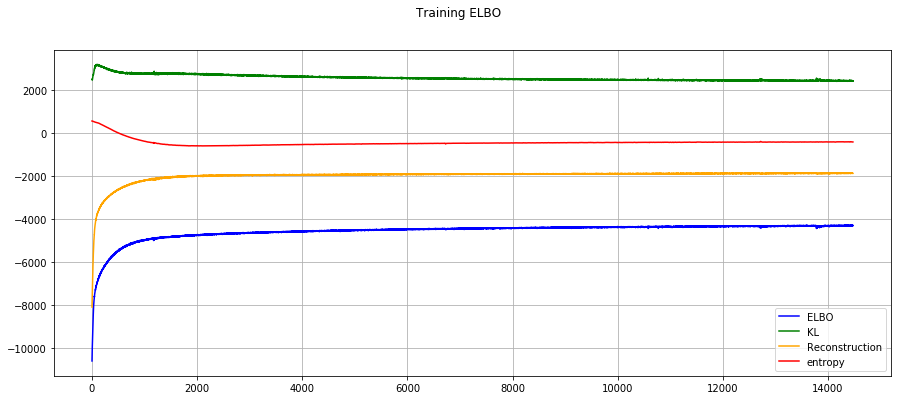

In [11]:
# Plot with GRUs
plt.subplots(1,1,figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(kls, 'g', label='KL')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(entropies, 'r', label='entropy')
plt.plot(entropy)
plt.suptitle('Training ELBO')
plt.grid("on")
plt.legend();

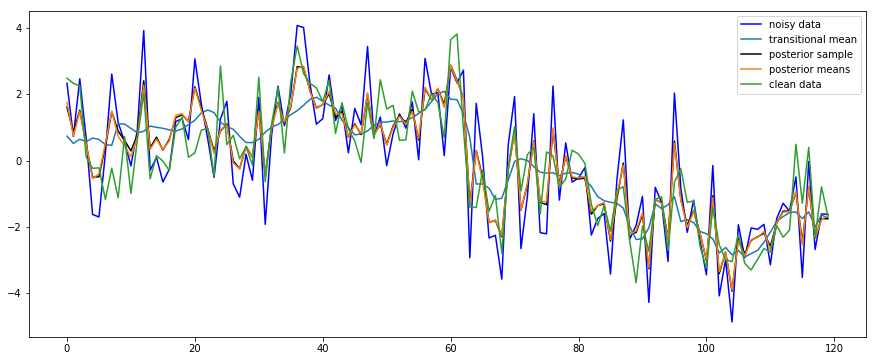

In [16]:
# Plot with GRU
plt.subplots(1,1,figsize=(15,6))
trans_means = np.mean(m.reshape(15*15, 10, 120), 0)
i = 6; t = i * 10
plt.plot(batch[i], 'b', label='noisy data')
plt.plot(trans_means[i], label='transitional mean')
# plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(latents.reshape(15*15, 10, 120), 0)[i], 'k', label='posterior sample')
plt.plot(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]})[i], 
          label='posterior means')
plt.plot(y[(1+t):(1+t+seq_length)], label='clean data')
plt.legend();

In [ ]:
# Best forward pred at 2500 iters
code = sess.run(gen_model.make_forward_parameters, {x_: test_batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(15, 6))
plt.plot(y_tilde[0, :seq_length], label='noisy data')
plt.plot(np.concatenate([y[1:seq_length+1], code[:, None]], 0), 'r', label='prediction')
plt.plot(y[1:seq_length+101], label='clean data')
plt.legend()
plt.suptitle("Best forward prediction");